### 오토인코더 모델을 활용한 신용카드 사기 예측하기

### 


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, 
precision_score, accuracy_score, f1_score, auc, roc_curve

In [ ]:
%load_ext tensorboard

In [2]:
# 데이터 가져오기. 
raw_data = pd.read_csv("/Users/jk/git/Study/Data/kaggle_dataset/credit_fraud/creditcard.csv")
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [3]:
show_data1 = raw_data.loc[:, ['Time', 'Amount', 'Class']]
show_data1.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
fraud_data = show_data1[show_data1.Class == 1]
normal_data = show_data1[show_data1.Class == 0]

Text(0, 0.5, 'Amount')

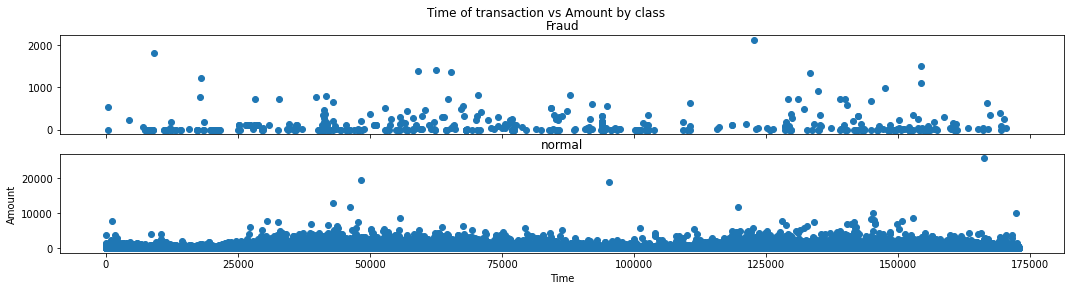

In [5]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(18, 4))
fig.suptitle('Time of transaction vs Amount by class')

axes[0].scatter(x=fraud_data.Time, y=fraud_data.Amount)
axes[0].set_title("Fraud")

axes[1].scatter(x=normal_data.Time, y=normal_data.Amount)
axes[1].set_title("normal")

plt.xlabel("Time")
plt.ylabel("Amount")

/Users/jk/setup/anaconda3/envs/python_pro2net/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jk/setup/anaconda3/envs/python_pro2net/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


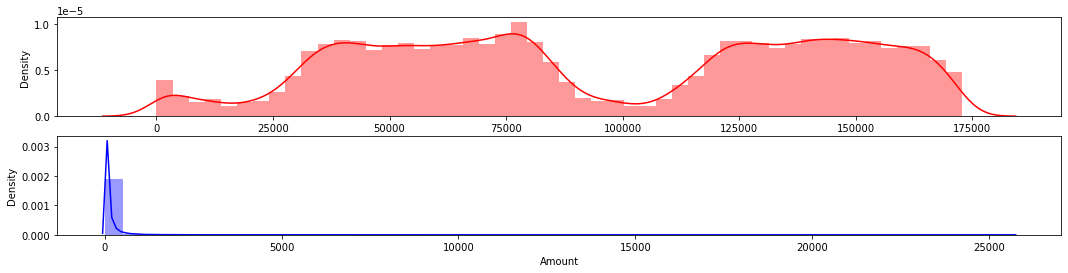

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(18, 4))

sns.distplot(show_data1.Time, ax=ax[0], color="r")

sns.distplot(show_data1.Amount, ax=ax[1], color="b")

plt.show()

Text(0.5, 1.0, 'Amount vs Class')

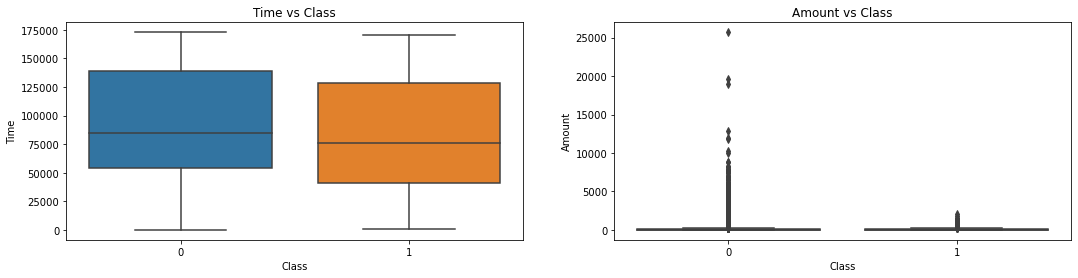

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.boxplot(x="Class", y="Time", data=show_data1, ax=ax[0])
ax[0].set_title("Time vs Class")

sns.boxplot(x="Class", y="Amount", data=show_data1, ax=ax[1])
ax[1].set_title("Amount vs Class")

In [8]:
# Time, Amount Scaling 작업


standard_scaler = StandardScaler()
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()
show_data1["s_scaler_time"] = standard_scaler.fit_transform(show_data1["Time"].values.reshape(-1, 1))    # 행이 -1이면 자동으로 결정
show_data1["r_scaler_time"] = robust_scaler.fit_transform(show_data1["Time"].values.reshape(-1, 1))
show_data1["m_scaler_time"] = minmax_scaler.fit_transform(show_data1["Time"].values.reshape(-1, 1))
show_data1["s_scaler_amount"] = standard_scaler.fit_transform(show_data1["Amount"].values.reshape(-1, 1))
show_data1["r_scaler_amount"] = robust_scaler.fit_transform(show_data1["Amount"].values.reshape(-1, 1))
show_data1["m_scaler_amount"] = minmax_scaler.fit_transform(show_data1["Amount"].values.reshape(-1, 1))
show_data1

,Time,Amount,Class,s_scaler_time,r_scaler_time,m_scaler_time,s_scaler_amount,r_scaler_amount,m_scaler_amount
0,0.0,149.62,0,-1.996583,-0.994983,0.000000,0.244964,1.783274,0.005824
1,0.0,2.69,0,-1.996583,-0.994983,0.000000,-0.342475,-0.269825,0.000105
2,1.0,378.66,0,-1.996562,-0.994972,0.000006,1.160686,4.983721,0.014739
3,1.0,123.50,0,-1.996562,-0.994972,0.000006,0.140534,1.418291,0.004807
4,2.0,69.99,0,-1.996541,-0.994960,0.000012,-0.073403,0.670579,0.002724
...,...,...,...,...,...,...,...,...,...
284802,172786.0,0.77,0,1.641931,1.034951,0.999965,-0.350151,-0.296653,0.000030
284803,172787.0,24.79,0,1.641952,1.034963,0.999971,-0.254117,0.038986,0.000965
284804,172788.0,67.88,0,1.641974,1.034975,0.999977,-0.081839,0.641096,0.002642
284805,172788.0,10.00,0,1.641974,1.034975,0.999977,-0.313249,-0.167680,0.000389


<AxesSubplot:title={'center':'heatmap for variable'}>

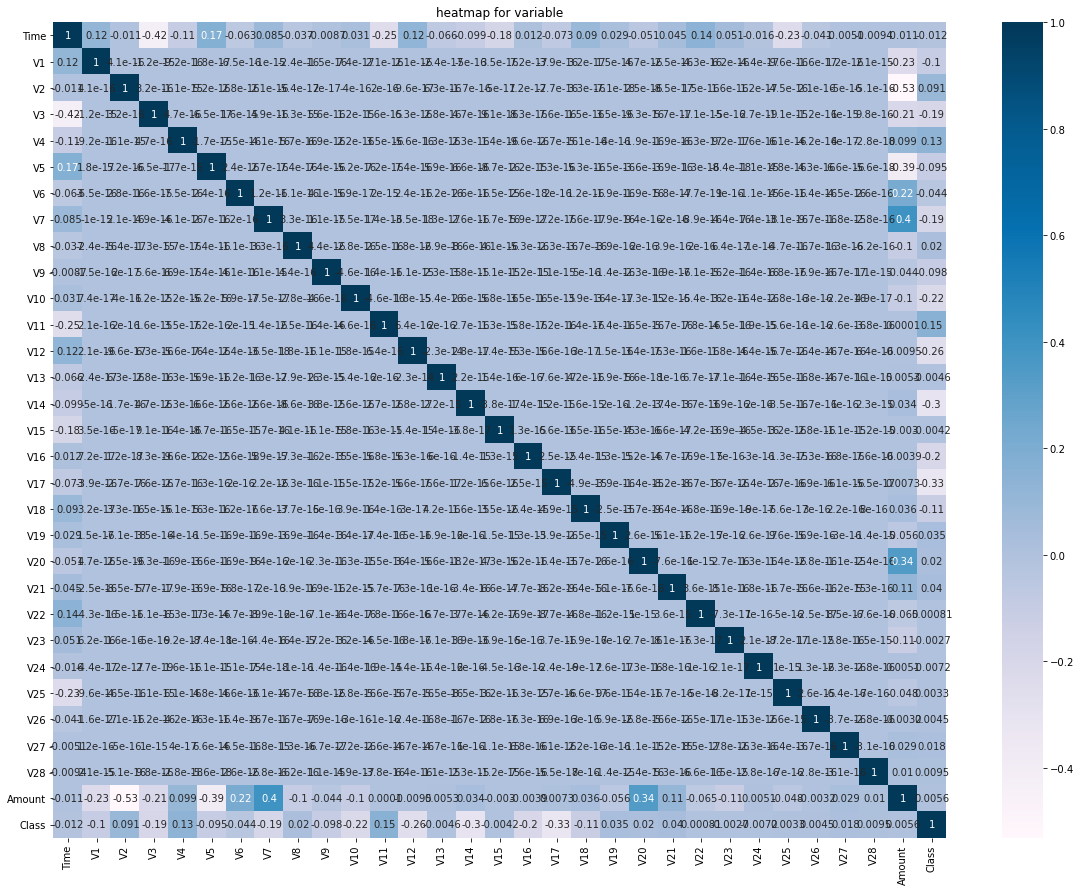

In [9]:
# 히트맵 그리기
plt.figure(figsize=(20, 15))           # 도화지 그리기
plt.title("heatmap for variable")

sns.heatmap(raw_data.corr(), linecolor="white", cmap=plt.cm.PuBu, annot=True)    # 그림그리기.

<AxesSubplot:xlabel='Class', ylabel='m_scaler_amount'>

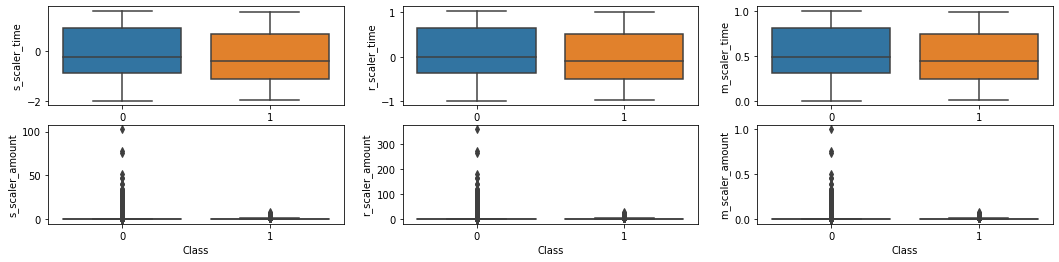

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(18, 4))

sns.boxplot(x="Class", y="s_scaler_time", data=show_data1, ax=ax[0][0])
sns.boxplot(x="Class", y="r_scaler_time", data=show_data1, ax=ax[0][1])
sns.boxplot(x="Class", y="m_scaler_time", data=show_data1, ax=ax[0][2])

sns.boxplot(x="Class", y="s_scaler_amount", data=show_data1, ax=ax[1][0])
sns.boxplot(x="Class", y="r_scaler_amount", data=show_data1, ax=ax[1][1])
sns.boxplot(x="Class", y="m_scaler_amount", data=show_data1, ax=ax[1][2])

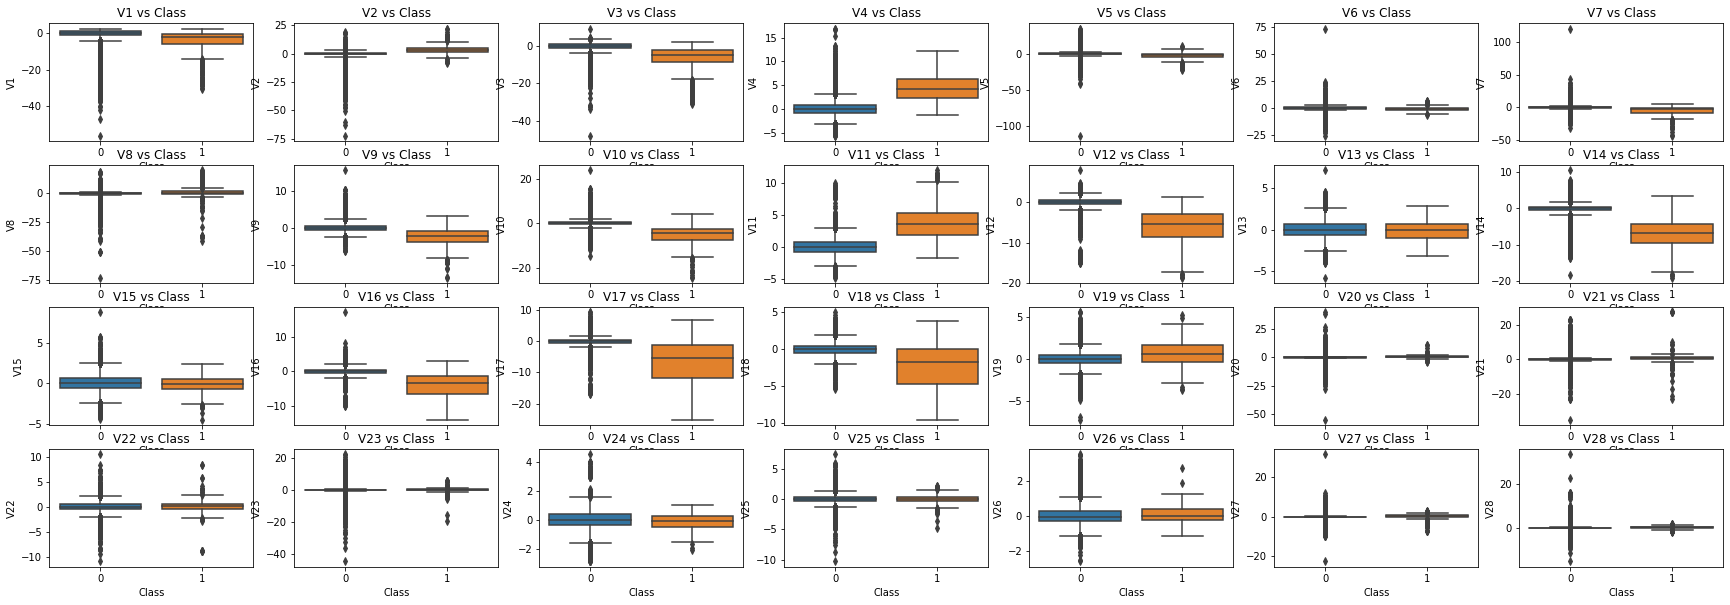

In [11]:
# time 빼고 나머지. 
fig, ax = plt.subplots(4, 7, figsize=(30, 10))

for num in range(28):
    i = num // 7
    j = num % 7
    y = "V" + str(num+1)
    sns.boxplot(x="Class", y=y, data=raw_data, ax=ax[i][j])
    ax[i][j].set_title(y + " vs Class")


# 좋아보이는 것 : 3, 4, 9,10,11,12, 14, 16, 17, 18, 19,
# 안 좋아보이는 것 : 5, 13, 15, 20, 21, 22, 24, 25, 27, 28

In [12]:
# RobustScaling
def robo_scaling(data, col_name):
    robustscaling = RobustScaler()
    new_col = robustscaling.fit_transform(data[col_name].values.reshape(-1, 1))
    return new_col

In [13]:
col_names = raw_data.columns[:-1]
scale_data = raw_data.copy()

for name in col_names:
    new_col = robo_scaling(raw_data, name)
    scale_data[name] = new_col


In [14]:
# 새로운 데이터 스케일링
scale_data2 = raw_data.copy()

# standardscaler
# scale_data2["Time"] = standard_scaler.fit_transform(scale_data2["Time"].values.reshape(-1, 1))
# scale_data2["Amount"] = standard_scaler.fit_transform(scale_data2["Amount"].values.reshape(-1, 1))

# robust_scaler
scale_data2["Time"] = robust_scaler.fit_transform(scale_data2["Time"].values.reshape(-1, 1))
scale_data2["Amount"] = robust_scaler.fit_transform(scale_data2["Amount"].values.reshape(-1, 1))

In [15]:
# minmax
def minmax_scaling(data, col_name):
    mmsc = MinMaxScaler()
    new_col = mmsc.fit_transform(data[col_name].values.reshape(-1, 1))
    return new_col

In [16]:
col_names = scale_data2.columns[:-1]
scale_data = scale_data2.copy()

for name in col_names:
    new_col = minmax_scaling(scale_data, name)
    scale_data[name] = new_col


In [17]:
# null 값 없음. 
scale_data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [18]:
# outlier 제거. 가장 상관계수가 높은 두 컬럼을 제거.

def remove_outlier(data, col_name):
    new_data = data.copy()
    Q1, Q3 = np.percentile(new_data[col_name], [25, 75])
    IQR_15 = (Q3 - Q1)*1.5
    upper_bound = Q3 + IQR_15
    lower_bound = Q1 - IQR_15
    new_data = new_data[((new_data.Class == 0) & (new_data[col_name] > lower_bound) & (new_data[col_name] < upper_bound)) | (new_data.Class == 1)]
    return new_data
    

In [19]:
new_data = remove_outlier(scale_data, "V14")
new_data = remove_outlier(new_data, "V17")
new_data = new_data.drop("Time", axis=1)
# print("제거된 숫자", len(raw_data) - len(new_data))


In [20]:
# 데이터 분할 및 셔플, 
# 정상과 비정상 데이터를 구분한 후 정상데이터를 6:2:2로 구분(train:val:test)
# 비정상 데이터의 경우 5:5로 나누어 val와 test 데이터에 분배 후 각 데이터셋 셔플

# 정상과 비정상 데이터로 분할
nor_dataset = new_data[new_data.Class == 0]
abnor_dataset = new_data[new_data.Class == 1]

# 정상, 비정상 데이터를 6:2:2로 분할
train_nor_dataset, val_nor_dataset, test_nor_dataset = np.split(nor_dataset, [int(0.6*len(nor_dataset)), int(0.8*len(nor_dataset))])

# print(len(train_nor_dataset) / len(nor_dataset), len(val_nor_dataset) / len(nor_dataset), len(test_nor_dataset) / len(nor_dataset))
# print(len(val_abnor_dataset) / len(abnor_dataset), len(test_abnor_dataset) / len(abnor_dataset))

In [21]:
# 데이터 병합 - merge
train_dataset = train_nor_dataset.sample(frac=1.0, random_state=152).reset_index(drop=True)
val_dataset = val_nor_dataset.sample(frac=1.0, random_state=152).reset_index(drop=True)
test_dataset = test_nor_dataset.append(abnor_dataset).sample(frac=1.0, random_state=152).reset_index(drop=True)

print(len(train_dataset) / len(new_data) * 100)
print(len(val_dataset) / len(new_data) * 100)
print(len(test_dataset) / len(new_data) * 100)
# 59.8893, 19.9633, 20.1472
train_dataset = train_dataset.drop("Class", axis=1)
val_dataset = val_dataset.drop("Class", axis=1)
train_dataset.shape

59.88935613494066
19.963367909541162
20.147275955518175


(160219, 29)

In [22]:
# 모델 만들기 - functional API
# input
input_dim = train_dataset.shape[1]
latent_dim = 4
learning_rate = 0.0000001
batch_size = 64
nb_epoch = 50
inputs = tf.keras.layers.Input(shape=(input_dim,))
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))


# layer 29, 14, 7, 14, 29
def create_encoder(inputs):
    x = tf.keras.layers.Dense(14, activation="tanh", 
                              activity_regularizer=tf.keras.regularizers.l2(learning_rate))(inputs)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(7, activation="relu")(x)
    latent = tf.keras.layers.Dense(latent_dim, activation="relu")(x)
    return latent

def create_decoder(latent_vector):
    x = tf.keras.layers.Dense(7, activation="relu")(latent_vector)
    x = tf.keras.layers.Dense(14, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(input_dim, activation="tanh")(x)
    return outputs

encoder = tf.keras.models.Model(inputs=inputs, outputs=create_encoder(inputs), name="ae_encoder")
decoder = tf.keras.models.Model(inputs=latent_inputs, outputs=create_decoder(latent_inputs), name="ae_decoder")
autoencoder = tf.keras.models.Model(inputs=inputs, outputs=decoder(encoder(inputs)), name="autoencoder_basic")
autoencoder.summary()



Model: "autoencoder_basic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
ae_encoder (Functional)      (None, 4)                 557       
_________________________________________________________________
ae_decoder (Functional)      (None, 29)                582       
Total params: 1,139
Trainable params: 1,139
Non-trainable params: 0
_________________________________________________________________


In [23]:


# 콜백 함수 정리. checkpoint, early stoppinng, tensorboard
# mode = monitor값이 min으로 할래 max으로 할래
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_basic",
                                       mode="min", monitor="val_loss",
                                       verbose=2, save_best_only=True)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode="min",
    restore_best_weights=True
)

log_dir = "ae_basic_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


autoencoder.compile(metrics=['acc'],
                   loss="mean_squared_error",
                   optimizer='adam')


In [25]:
history = autoencoder.fit(train_dataset, train_dataset,
                         epochs=nb_epoch,
                         batch_size=batch_size,
                         shuffle=False,
                         validation_data=(val_dataset, val_dataset),
                         verbose=1,
                         callbacks=[cp, early_stop, tensorboard]
                         ).history

Epoch 1/50
2504/2504 [==============================] - 3s 1ms/step - loss: 0.0170 - acc: 0.8229 - val_loss: 0.0017 - val_acc: 0.9950

Epoch 00001: val_loss improved from inf to 0.00168, saving model to autoencoder_basic
INFO:tensorflow:Assets written to: autoencoder_basic/assets
Epoch 2/50
2504/2504 [==============================] - 2s 938us/step - loss: 0.0023 - acc: 0.9919 - val_loss: 0.0016 - val_acc: 0.9950

Epoch 00002: val_loss improved from 0.00168 to 0.00165, saving model to autoencoder_basic
INFO:tensorflow:Assets written to: autoencoder_basic/assets
Epoch 3/50
2504/2504 [==============================] - 2s 955us/step - loss: 0.0015 - acc: 0.9954 - val_loss: 0.0013 - val_acc: 0.9950

Epoch 00003: val_loss improved from 0.00165 to 0.00128, saving model to autoencoder_basic
INFO:tensorflow:Assets written to: autoencoder_basic/assets
Epoch 4/50
2504/2504 [==============================] - 3s 1ms/step - loss: 0.0012 - acc: 0.9955 - val_loss: 0.0011 - val_acc: 0.9950

Epoch 0000

In [26]:
%tensorboard --logdir ae_basic_logs/fit/20211004-205957

In [27]:
test_dataset_label = test_dataset["Class"]
test_dataset_data = test_dataset.drop("Class", axis=1)


pred = autoencoder.predict(test_dataset_data)
mse = np.mean(np.power(test_dataset_data-pred, 2), axis=1)
error_df = pd.DataFrame({"Reconstruction_error": mse,
                        "True_class": test_dataset_label})
error_df

,Reconstruction_error,True_class
0,0.000841,0
1,0.000471,0
2,0.000643,0
3,0.001148,0
4,0.001549,0
...,...,...
53894,0.000538,0
53895,0.000612,0
53896,0.000783,0
53897,0.000580,0


Text(0.5, 0, 'Data point index')

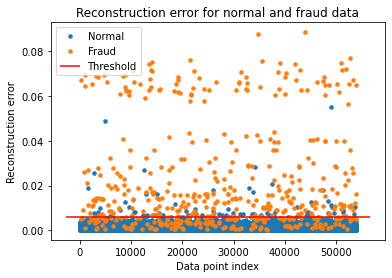

In [37]:
th = 0.006
true_group = error_df.groupby("True_class")
true_group
fig, ax = plt.subplots()
for name, group in true_group:
    ax.plot(group.index, group.Reconstruction_error, marker="o", ms=3.5, linestyle='',
           label="Fraud" if name == 1 else "Normal")
ax.hlines(th, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', zorder=100, label="Threshold")
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")


Accuracy :  0.9957142062004861
Recall :  0.6890243902439024
Precision :  0.8129496402877698
f1_score :  0.7458745874587459
auc :  0.9589190144527505


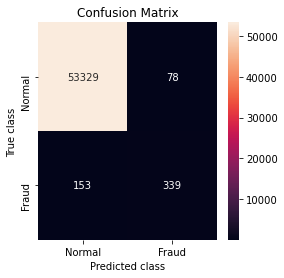

In [38]:


LABELS = ["Normal", "Fraud"]
pred_y = [1 if e > th else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] = pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
fpr, tpr, th = roc_curve(error_df.True_class, error_df.Reconstruction_error)
# print(th.all())

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted class")
plt.ylabel("True class")

print("Accuracy : ", accuracy_score(error_df["True_class"], error_df["pred"]))
print("Recall : ", recall_score(error_df["True_class"], error_df["pred"]))
print("Precision : ", precision_score(error_df["True_class"], error_df["pred"]))
print("f1_score : ", f1_score(error_df["True_class"], error_df["pred"]))
print("auc : ", auc(fpr, tpr))    # 0.9589
# th : recall, f1_score, auc
# 0.008 : 0.6036, 0.7113
# 0.007 : 0.6361, 0.7137
# 0.006 : 0.6890, 0.7197 
# 0.006, Time 제거 : 0.6890, 0.7458 --- o
# 0.0055 : 0.7174, 0.7138
# 0.005 : 0.7621, 0.6931
# 0.004 : 0.8170, 0.4693